In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.signal import find_peaks, butter, filtfilt
from scipy.fftpack import fft
from scipy.integrate import trapezoid
from sklearn.decomposition import PCA

In [2]:
# -------------------------------
# 1. Load IMU Data
# -------------------------------
def load_imu_data(file_path):
    data = pd.read_csv(file_path)
    data["Time(s)"] = data["Time(ms)"] / 1000.0  # Convert time to seconds
    return data

def load_force_data(file_path):
    data = pd.read_csv(file_path)
    data["Time(s)"] = data["Time(ms)"] / 1000.0
    return data

# -------------------------------
# 2. Apply Butterworth Filter and High-pass Filter
# -------------------------------
def butter_lowpass_filter(data, cutoff=5, fs=100, order=2):
    nyquist = 0.5 * fs
    normal_cutoff = cutoff / nyquist
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    return filtfilt(b, a, data)

def high_pass_filter(data, cutoff=0.1, fs=100, order=2):
    nyquist = 0.5 * fs
    normal_cutoff = cutoff / nyquist
    b, a = butter(order, normal_cutoff, btype='high', analog=False)
    return filtfilt(b, a, data)

# -------------------------------
# 3. Compute Joint Angles (Knee, Hip, Ankle)
# -------------------------------
def integrate_gyro(gyro_data, time, initial_angle=0):
    angle = np.cumsum(gyro_data * np.gradient(time))  # Numerical Integration
    return angle - np.mean(angle[:50]) + initial_angle  # Drift Correction

# -------------------------------
# 4. Detect Heel Strikes & Toe-Offs (Using GyroZ of Ankle)
# -------------------------------
def detect_gait_events(gyroZ, time, threshold=20):
    peaks, _ = find_peaks(gyroZ, height=threshold)  # Toe-off detection
    valleys, _ = find_peaks(-gyroZ, height=threshold)  # Heel-strike detection
    return time[peaks], time[valleys]

# -------------------------------
# 5. Compute Temporal Gait Parameters
# -------------------------------
def compute_temporal_parameters(heel_strikes):
    step_times = np.diff(heel_strikes)  # Time between heel strikes
    stride_times = step_times[::2]  # Stride time is every two steps
    cadence = 60 / np.mean(step_times)  # Steps per minute
    step_time_variability = np.std(step_times)  # Step variability
    return step_times, stride_times, cadence, step_time_variability

# -------------------------------
# 6. Compute Spatial Gait Parameters
# -------------------------------
def compute_step_length(accelY, time):
    velocity = np.cumsum(accelY * np.gradient(time))  # Integrate acceleration
    step_length = trapezoid(velocity, time) / len(time)  # Approximate distance per step
    return step_length

# -------------------------------
# 7. Compute Gait Symmetry & Interlimb Coordination
# -------------------------------
def compute_gait_symmetry(left_steps, right_steps):
    step_time_diff = np.abs(np.mean(left_steps) - np.mean(right_steps))
    stride_symmetry_index = (np.abs(np.mean(left_steps) - np.mean(right_steps)) / (np.mean(left_steps) + np.mean(right_steps))) * 100
    return step_time_diff, stride_symmetry_index

# -------------------------------
# 8. Identify Knee Joint Axis using PCA
# -------------------------------
def identify_joint_axis(gyro_data):
    """
    Uses PCA to identify the dominant rotation axis (joint axis).
    Input: Gyroscope data (GyroX, GyroY, GyroZ) as a DataFrame.
    Output: Principal component (joint axis vector).
    """
    pca = PCA(n_components=1)  # Extract the primary motion axis
    pca.fit(gyro_data)  # Fit PCA on angular velocities
    joint_axis = pca.components_[0]  # Principal component (dominant axis)
    return joint_axis

# -------------------------------
# 9. Project Gyroscope Data onto Identified Knee Joint Axis
# -------------------------------
def project_onto_joint_axis(gyro_data, joint_axis):
    """
    Projects the gyroscope readings onto the identified knee joint axis.
    Input: Gyroscope data (GyroX, GyroY, GyroZ) and joint axis vector.
    Output: Rotational velocity around the identified knee joint axis.
    """
    return np.dot(gyro_data, joint_axis)


# -------------------------------
# 10. Load Data and Perform Analysis
# -------------------------------
#./dataset_formatted/abhijith-singularcycle/test2/LA.csv
# New_Dataset/dataset_formatted/abhijith-singularcycle/test2
left_thigh_file = "../dataset_formatted/abhijith-singularcycle/test2/LT.csv"
left_shank_file = "../dataset_formatted/abhijith-singularcycle/test2/LS.csv"
left_ankle_file = "../dataset_formatted/abhijith-singularcycle/test2/LA.csv"
right_thigh_file = "../dataset_formatted/abhijith-singularcycle/test2/RT.csv"
right_shank_file = "../dataset_formatted/abhijith-singularcycle/test2/RS.csv"
right_ankle_file = "../dataset_formatted/abhijith-singularcycle/test2/RA.csv"
left_force_file = "../Test_13-3-2025/Specimen_1/Left_Force/test1.csv"
right_force_file = "../Test_13-3-2025/Specimen_1/Right_Force/test1.csv"

In [3]:
left_thigh_data = load_imu_data(left_thigh_file)
left_shank_data = load_imu_data(left_shank_file)
left_ankle_data = load_imu_data(left_ankle_file)
right_thigh_data = load_imu_data(right_thigh_file)
right_shank_data = load_imu_data(right_shank_file)
right_ankle_data = load_imu_data(right_ankle_file)
left_force_data = load_force_data(left_force_file)
right_force_data = load_force_data(right_force_file)

1050
1050
1050
1050
1050
1050


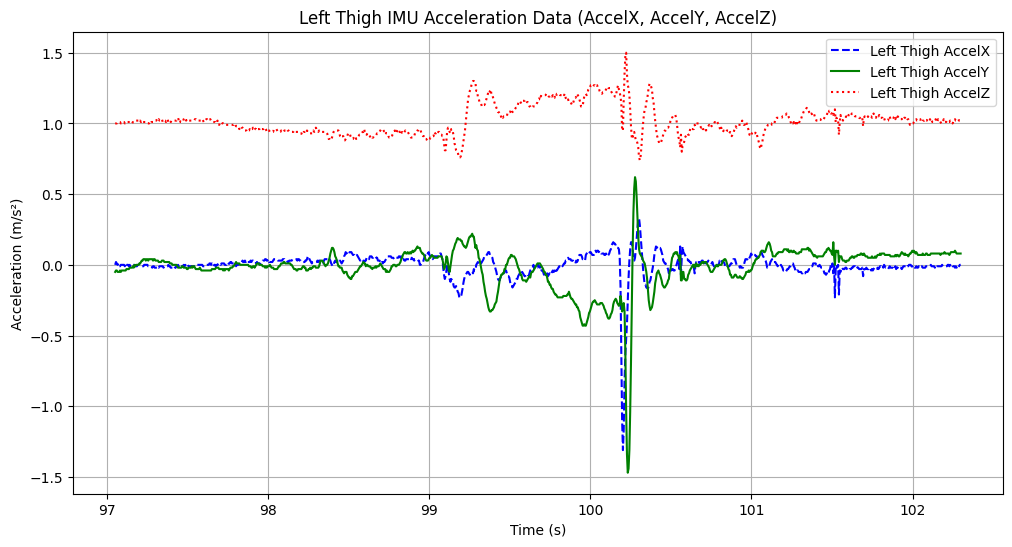

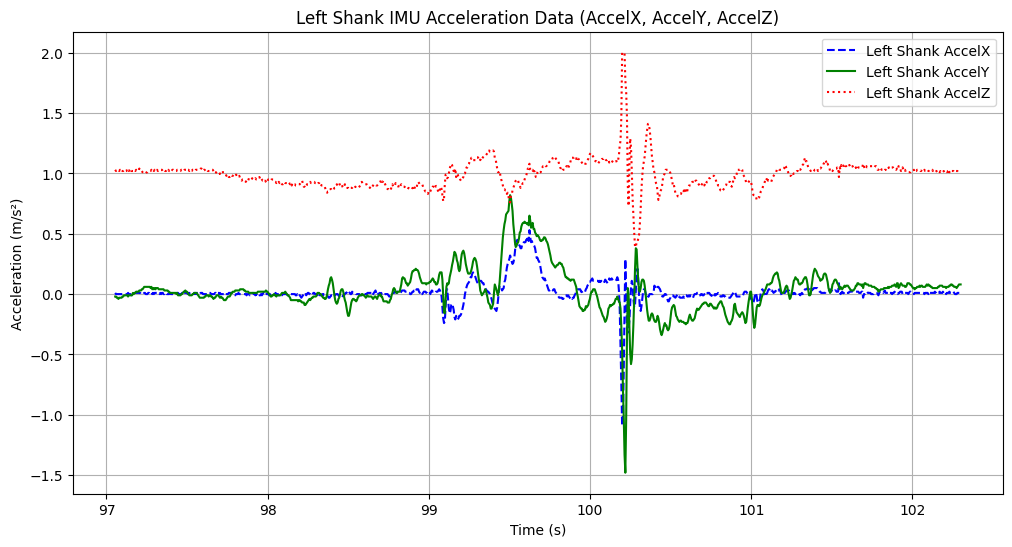

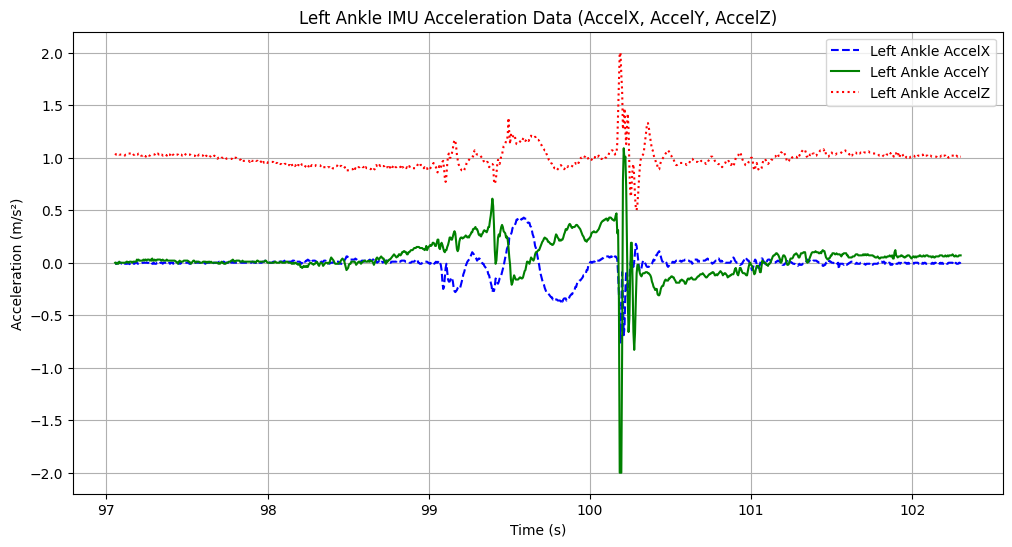

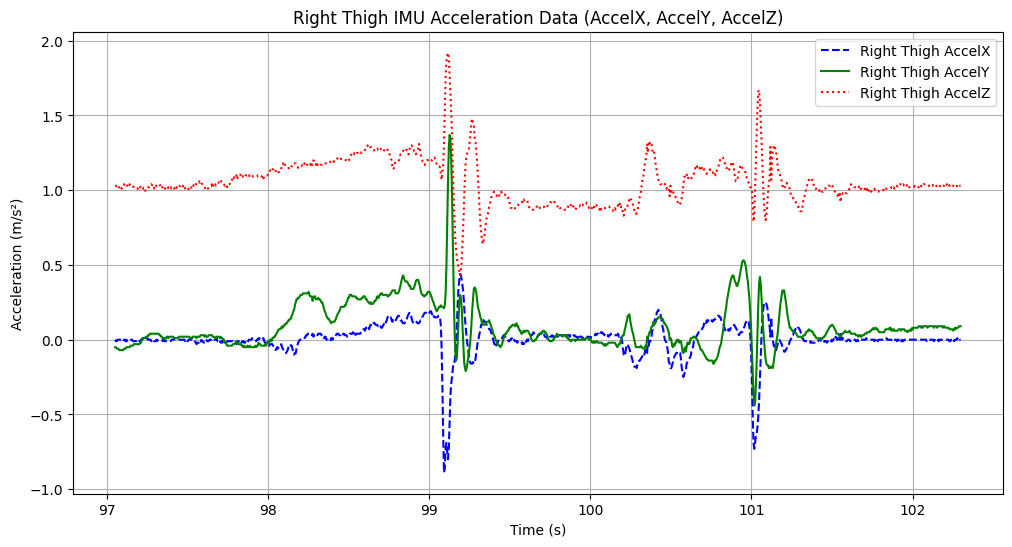

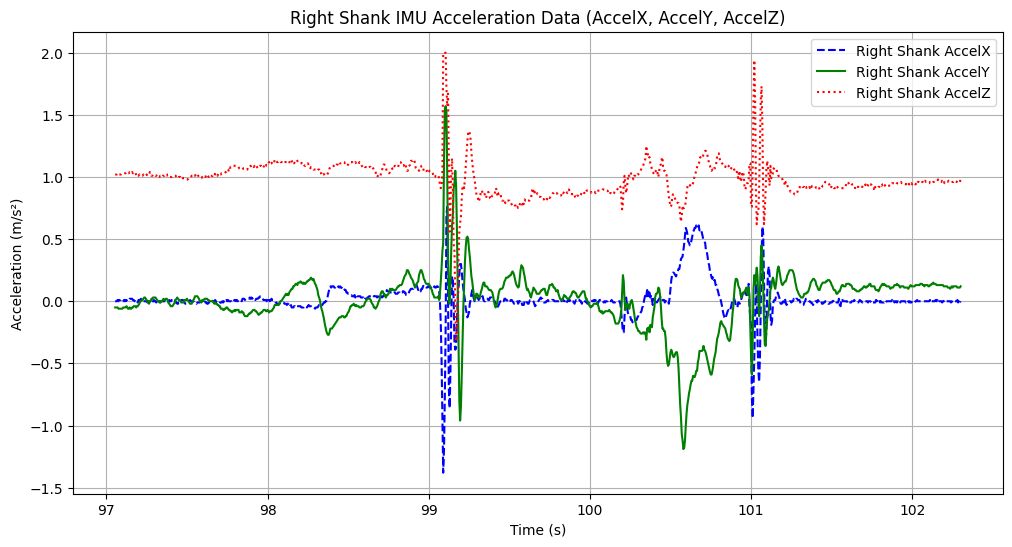

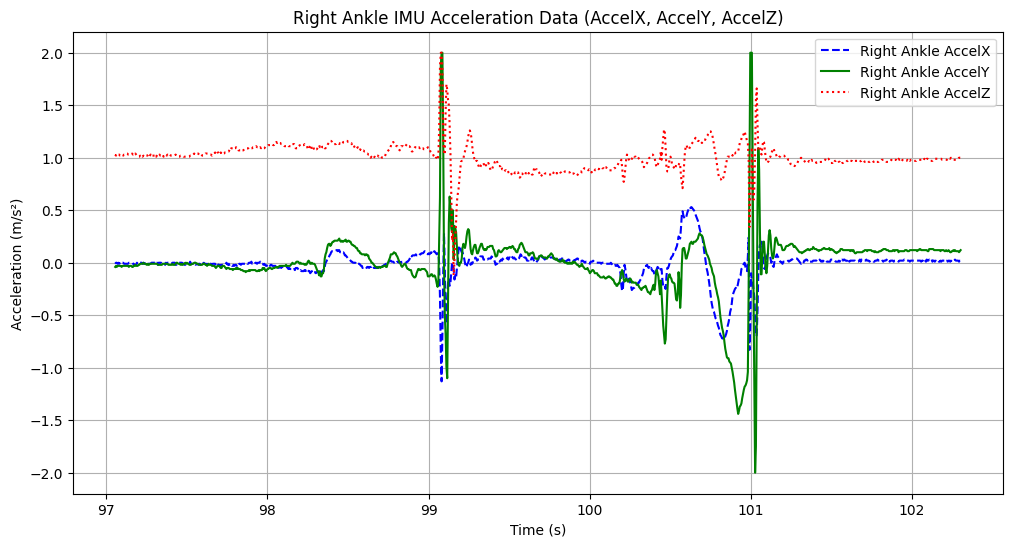

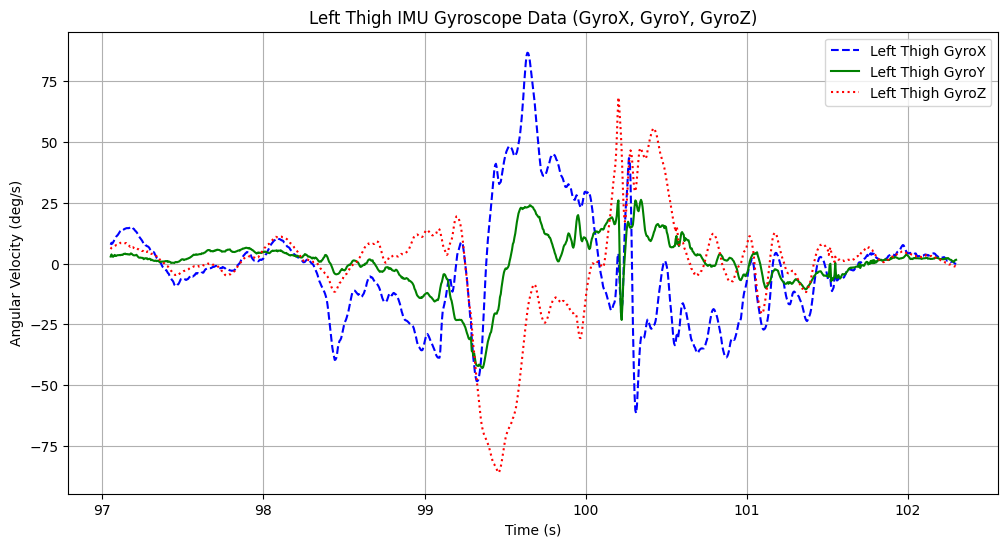

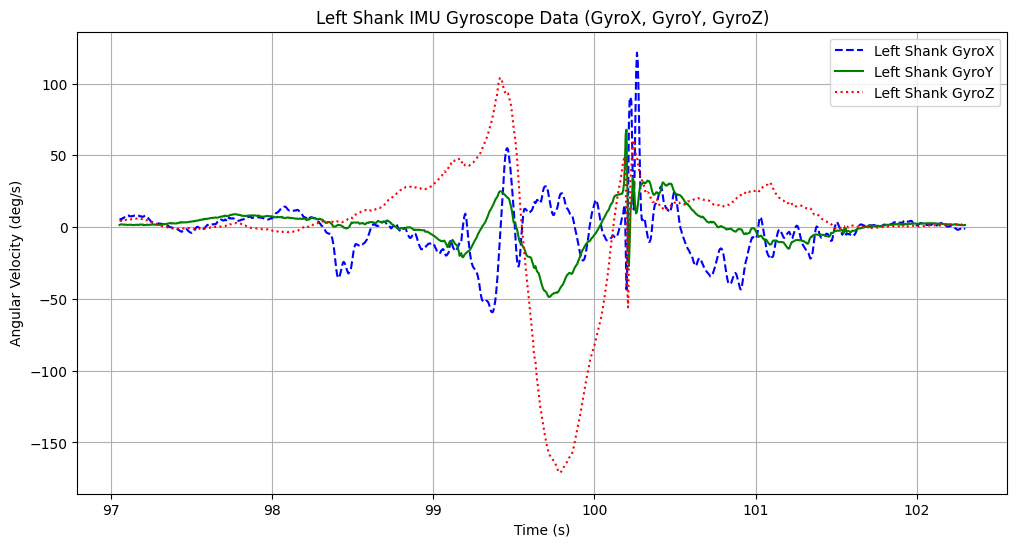

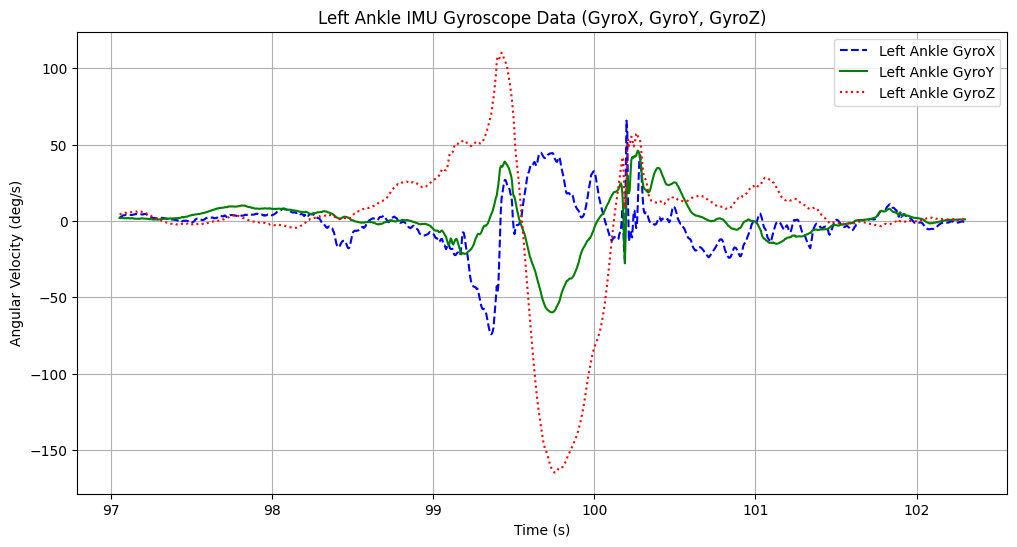

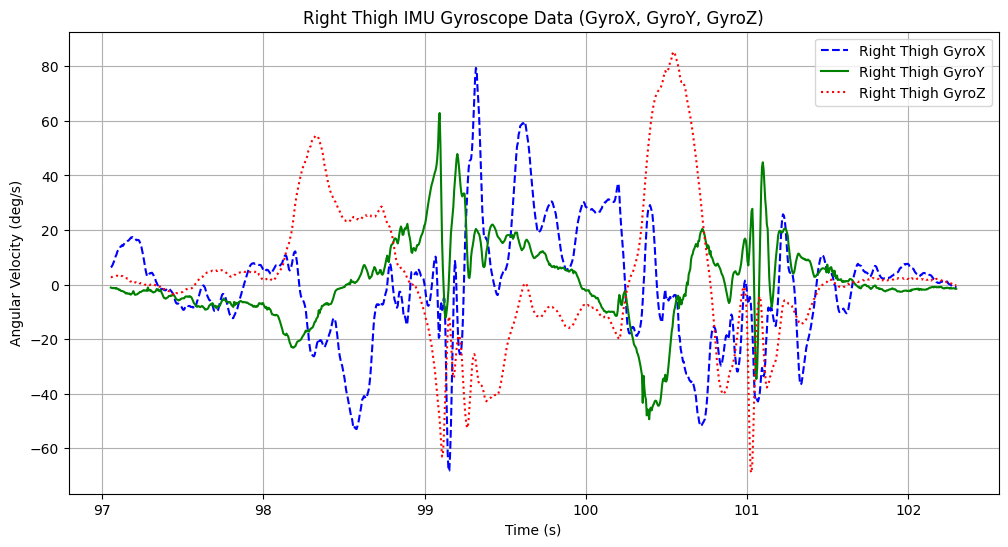

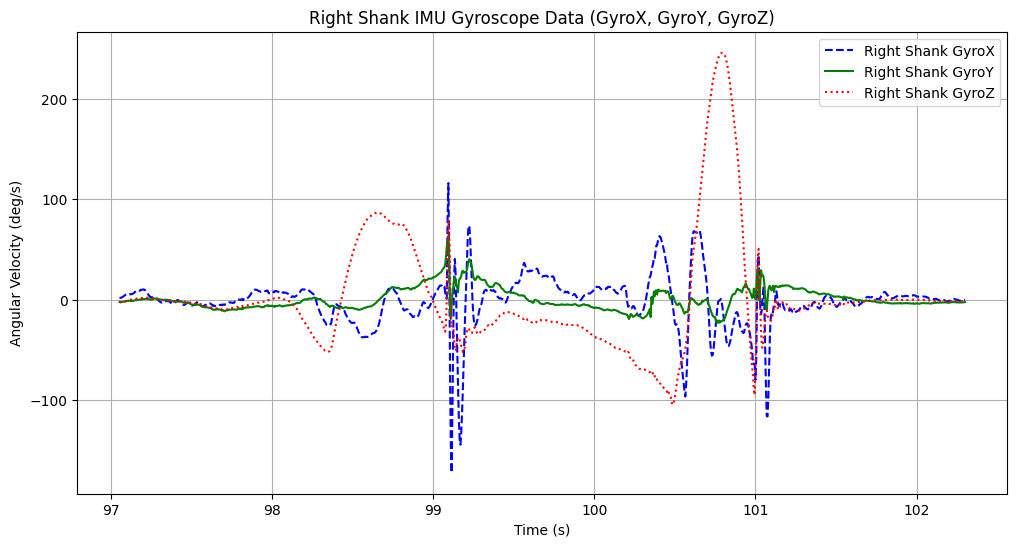

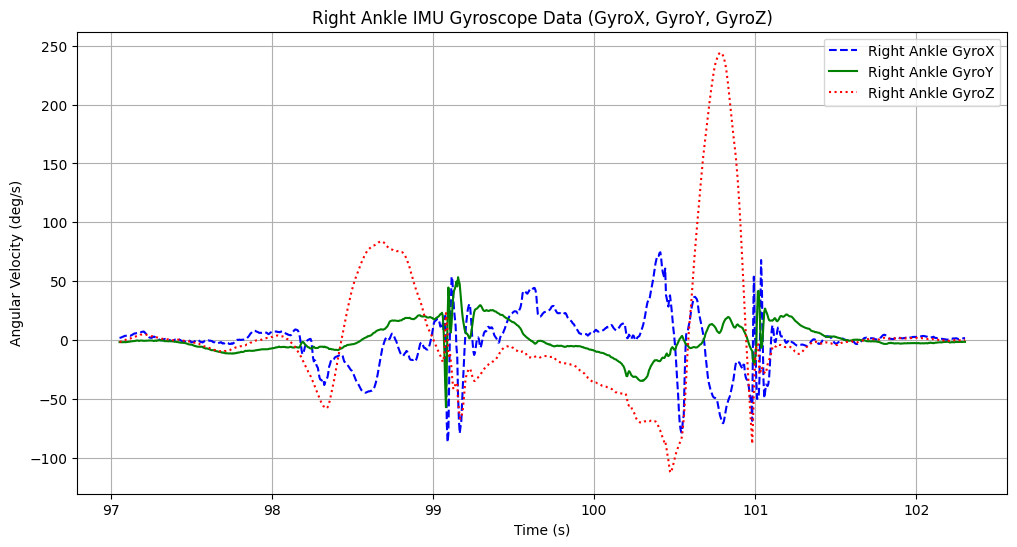

In [15]:
import matplotlib.pyplot as plt

# Define sensor names
sensors = {
    "Left Thigh": left_thigh_data,
    "Left Shank": left_shank_data,
    "Left Ankle": left_ankle_data,
    "Right Thigh": right_thigh_data,
    "Right Shank": right_shank_data,
    "Right Ankle": right_ankle_data,
}

print(len(left_thigh_data))
print(len(right_thigh_data))
print(len(left_shank_data))
print(len(right_shank_data))
print(len(left_ankle_data))
print(len(right_ankle_data))


# Define colors for each sensor
colors = ["blue", "green", "red", "orange", "purple", "brown"]

# -------------------------------
# Plot Acceleration Data (AccelX, AccelY, AccelZ) for each joint separately
# -------------------------------
joints = ['Left Thigh', 'Left Shank', 'Left Ankle', 'Right Thigh', 'Right Shank', 'Right Ankle']
for joint in joints:
    data = sensors[joint]
    
    plt.figure(figsize=(12, 6))
    
    # Plot AccelX, AccelY, AccelZ
    plt.plot(data["Time(s)"], data["AccelX"], label=f"{joint} AccelX", linestyle="dashed", color='b')
    plt.plot(data["Time(s)"], data["AccelY"], label=f"{joint} AccelY", linestyle="solid", color='g')
    plt.plot(data["Time(s)"], data["AccelZ"], label=f"{joint} AccelZ", linestyle="dotted", color='r')

    plt.xlabel("Time (s)")
    plt.ylabel("Acceleration (m/s²)")
    plt.legend()
    plt.title(f"{joint} IMU Acceleration Data (AccelX, AccelY, AccelZ)")
    plt.grid()
    plt.show()

# -------------------------------
# Plot Gyroscope Data (GyroX, GyroY, GyroZ) for each joint separately
# -------------------------------
for joint in joints:
    data = sensors[joint]
    
    plt.figure(figsize=(12, 6))
    
    # Plot GyroX, GyroY, GyroZ
    plt.plot(data["Time(s)"], data["GyroX"], label=f"{joint} GyroX", linestyle="dashed", color='b')
    plt.plot(data["Time(s)"], data["GyroY"], label=f"{joint} GyroY", linestyle="solid", color='g')
    plt.plot(data["Time(s)"], data["GyroZ"], label=f"{joint} GyroZ", linestyle="dotted", color='r')

    plt.xlabel("Time (s)")
    plt.ylabel("Angular Velocity (deg/s)")
    plt.legend()
    plt.title(f"{joint} IMU Gyroscope Data (GyroX, GyroY, GyroZ)")
    plt.grid()
    plt.show()


In [10]:
fs = 100  

# Apply filtering
for data in [left_thigh_data, left_shank_data, left_ankle_data, right_thigh_data, right_shank_data, right_ankle_data]:
    data["GyroZ_filtered"] = butter_lowpass_filter(data["GyroZ"])
    data["GyroZ_filtered"] = high_pass_filter(data["GyroZ_filtered"], fs=fs)
    data["AccelY_filtered"] = butter_lowpass_filter(data["AccelY"])
    data["AccelY_filtered"] = high_pass_filter(data["AccelY_filtered"], fs=fs)
    data["GyroX_filtered"] = butter_lowpass_filter(data["GyroX"])
    data["GyroX_filtered"] = high_pass_filter(data["GyroX_filtered"], fs=fs)
    data["GyroY_filtered"] = butter_lowpass_filter(data["GyroY"])
    data["GyroY_filtered"] = high_pass_filter(data["GyroY_filtered"], fs=fs)


In [ ]:
# Extract gyroscope data for PCA
left_shank_gyro = left_shank_data[["GyroX_filtered", "GyroY_filtered", "GyroZ_filtered"]].to_numpy()
left_thigh_gyro = left_thigh_data[["GyroX_filtered", "GyroY_filtered", "GyroZ_filtered"]].to_numpy()
right_shank_gyro = right_shank_data[["GyroX_filtered", "GyroY_filtered", "GyroZ_filtered"]].to_numpy()
right_thigh_gyro = right_thigh_data[["GyroX_filtered", "GyroY_filtered", "GyroZ_filtered"]].to_numpy()

# Ensure both datasets have the same number of samples
min_length_left = min(len(left_shank_gyro), len(left_thigh_gyro))
min_length_right = min(len(right_shank_gyro), len(right_thigh_gyro))

# Trim the data to match lengths
left_shank_gyro = left_shank_gyro[:min_length_left]
left_thigh_gyro = left_thigh_gyro[:min_length_left]
right_shank_gyro = right_shank_gyro[:min_length_right]
right_thigh_gyro = right_thigh_gyro[:min_length_right]

# Identify knee joint axes using PCA
left_knee_axis = identify_joint_axis(left_shank_gyro - left_thigh_gyro)  # Difference for relative motion
right_knee_axis = identify_joint_axis(right_shank_gyro - right_thigh_gyro)

# Project gyroscope data onto knee joint axes
left_shank_proj = project_onto_joint_axis(left_shank_gyro, left_knee_axis)
left_thigh_proj = project_onto_joint_axis(left_thigh_gyro, left_knee_axis)
right_shank_proj = project_onto_joint_axis(right_shank_gyro, right_knee_axis)
right_thigh_proj = project_onto_joint_axis(right_thigh_gyro, right_knee_axis)

left_shank_proj = left_shank_proj[:min_length_left]
left_thigh_proj = left_thigh_proj[:min_length_left]
right_shank_proj = right_shank_proj[:min_length_right]
right_thigh_proj = right_thigh_proj[:min_length_right]

# Compute Knee Angles using PCA-identified axes
left_knee_angle = integrate_gyro(left_shank_proj - left_thigh_proj, left_shank_data["Time(s)"][:min_length_left])
right_knee_angle = integrate_gyro(right_shank_proj - right_thigh_proj, right_shank_data["Time(s)"][:min_length_right])

In [ ]:
# -------------------------------
# 7. Plot Results
# -------------------------------
plt.figure(figsize=(10, 5))
plt.plot(left_shank_data["Time(s)"][:min_length_left], left_knee_angle, label="Left Knee Angle", color='b')
plt.plot(right_shank_data["Time(s)"][:min_length_right], right_knee_angle, label="Right Knee Angle", color='r')
plt.xlabel("Time (s)")
plt.ylabel("Joint Angle (degrees)")
plt.legend()
plt.grid()
plt.title("Joint Angles Over Time (Using Identified Knee Joint Axis) PCA Approach")
plt.show()

In [ ]:
# Compute Joint Angles
left_knee_angle = integrate_gyro(left_shank_data["GyroZ_filtered"], left_shank_data["Time(s)"]) - integrate_gyro(left_thigh_data["GyroZ_filtered"], left_thigh_data["Time(s)"])
right_knee_angle = integrate_gyro(right_thigh_data["GyroZ_filtered"], right_thigh_data["Time(s)"]) - integrate_gyro(right_shank_data["GyroZ_filtered"], right_shank_data["Time(s)"])


In [ ]:
# -------------------------------
# 7. Plot Results
# -------------------------------
plt.figure(figsize=(10, 5))
plt.plot(left_shank_data["Time(s)"], left_knee_angle, label="Left Knee Angle", color='b')
plt.plot(right_shank_data["Time(s)"], right_knee_angle, label="Right Knee Angle", color='r')
plt.xlabel("Time (s)")
plt.ylabel("Joint Angle (degrees)")
plt.legend()
plt.grid()
plt.title("Joint Angles Over Time (Using Identified Knee Joint Axis)")
plt.show()

In [ ]:
# Detect Gait Events
left_heel_strikes, left_toe_offs = detect_gait_events(left_ankle_data["GyroZ_filtered"], left_ankle_data["Time(s)"],threshold=124)
right_heel_strikes, right_toe_offs = detect_gait_events(right_ankle_data["GyroZ_filtered"], right_ankle_data["Time(s)"],threshold=105)

# Compute Gait Parameters
left_step_times, left_stride_times, left_cadence, left_variability = compute_temporal_parameters(left_heel_strikes)
right_step_times, right_stride_times, right_cadence, right_variability = compute_temporal_parameters(right_heel_strikes)

# Compute Symmetry
step_time_diff, stride_symmetry_index = compute_gait_symmetry(left_step_times, right_step_times)

# # Detect Gait Events
# left_heel_strikes, left_toe_offs = detect_gait_events(left_ankle_data["GyroZ_filtered"], left_ankle_data["Time(s)"])
# right_heel_strikes, right_toe_offs = detect_gait_events(right_ankle_data["GyroZ_filtered"], right_ankle_data["Time(s)"], threshold=3.5)

# # Compute Gait Parameters
# left_step_times, left_stride_times, left_cadence, left_variability = compute_temporal_parameters(left_heel_strikes)
# right_step_times, right_stride_times, right_cadence, right_variability = compute_temporal_parameters(right_heel_strikes)

# # Compute Symmetry
# step_time_diff, stride_symmetry_index = compute_gait_symmetry(left_step_times, right_step_times)



In [ ]:
print("Left Heel Strikes:", len(left_heel_strikes))
print("Right Heel Strikes:", len(right_heel_strikes))
print("Left Cadence:", left_cadence)
print("Right Cadence:", right_cadence)
print("Step Time Difference:", step_time_diff)
print("Stride Symmetry Index:", stride_symmetry_index)
print("Left Variability:", left_variability)
print("Right Variability:", right_variability)
print("Left Step Length:", compute_step_length(left_ankle_data["AccelY"], left_ankle_data["Time(s)"]))
print("Right Step Length:", compute_step_length(right_ankle_data["AccelY"], right_ankle_data["Time(s)"]))
print("Left Toe Offs:", len(left_toe_offs))
print("Right Toe Offs:", len(right_toe_offs))

In [ ]:
# -------------------------------
# Print Summary Results
# -------------------------------
print(f"Left Cadence: {left_cadence:.2f} steps/min")
print(f"Right Cadence: {right_cadence:.2f} steps/min")
print(f"Step Time Difference: {step_time_diff:.2f} s")
print(f"Stride Symmetry Index: {stride_symmetry_index:.2f}%")


In [ ]:
# -------------------------------
# Plot Results
# -------------------------------
plt.figure(figsize=(10, 5))
plt.plot(left_shank_data["Time(s)"], left_knee_angle, label="Left Knee Angle", color='b')
plt.plot(right_shank_data["Time(s)"], right_knee_angle, label="Right Knee Angle", color='r')
plt.xlabel("Time (s)")
plt.ylabel("Joint Angle (degrees)")
plt.legend()
plt.grid()
plt.title("Joint Angles Over Time")
plt.show(block=True)

In [ ]:
# -------------------------------
# Plot Results
# -------------------------------
plt.figure(figsize=(10, 5))
# plt.plot(left_shank_data["Time(s)"], left_knee_angle, label="Left Knee Angle", color='b')
plt.plot(right_shank_data["Time(s)"], right_knee_angle, label="Right Knee Angle", color='r')
plt.xlabel("Time (s)")
plt.ylabel("Joint Angle (degrees)")
plt.legend()
plt.grid()
plt.title("Joint Angles Over Time")
plt.show(block=True)

In [ ]:
# -------------------------------
# Plot Results
# -------------------------------
plt.figure(figsize=(10, 5))
plt.plot(left_shank_data["Time(s)"], left_knee_angle, label="Left Knee Angle", color='b')
# plt.plot(right_shank_data["Time(s)"], right_knee_angle, label="Right Knee Angle", color='r')
plt.xlabel("Time (s)")
plt.ylabel("Joint Angle (degrees)")
plt.legend()
plt.grid()
plt.title("Joint Angles Over Time")
plt.show(block=True)

In [ ]:
# -------------------------------
# Plot Heel Strikes & Toe-Offs
# -------------------------------
plt.figure(figsize=(10, 5))

# Plot GyroZ for left ankle
plt.plot(left_shank_data["Time(s)"], left_shank_data["GyroZ_filtered"], label="Left Shank GyroZ", color='blue')
# plt.scatter(left_heel_strikes, [0] * len(left_heel_strikes), marker='o', color='red', label="Left Heel Strike")
# plt.scatter(left_toe_offs, [0] * len(left_toe_offs), marker='x', color='green', label="Left Toe-Off")

plt.xlabel("Time (s)")
plt.ylabel("GyroZ (deg/s)")
plt.legend()
plt.grid()
plt.title("Left Shank GyroZ")
plt.show(block=True)

In [ ]:
# -------------------------------
# Plot Heel Strikes & Toe-Offs
# -------------------------------
plt.figure(figsize=(10, 5))

# Plot GyroZ for left ankle
plt.plot(left_shank_data["Time(s)"], left_shank_data["GyroZ_filtered"], label="Left Shank GyroZ", color='blue')
plt.scatter(left_heel_strikes, [0] * len(left_heel_strikes), marker='o', color='red', label="Left Heel Strike")
plt.scatter(left_toe_offs, [0] * len(left_toe_offs), marker='x', color='green', label="Left Toe-Off")

plt.xlabel("Time (s)")
plt.ylabel("GyroZ (deg/s)")
plt.legend()
plt.grid()
plt.title("Heel Strikes and Toe-Offs Detection")
plt.show(block=True)

In [ ]:
# -------------------------------
# Plot Heel Strikes & Toe-Offs
# -------------------------------
plt.figure(figsize=(10, 5))

# Plot GyroZ for right ankle
plt.plot(right_shank_data["Time(s)"], right_shank_data["GyroZ_filtered"], label="Right Shank GyroZ", color='orange')
# plt.scatter(right_heel_strikes, [0] * len(right_heel_strikes), marker='o', color='purple', label="Right Heel Strike")
# plt.scatter(right_toe_offs, [0] * len(right_toe_offs), marker='x', color='brown', label="Right Toe-Off")

plt.xlabel("Time (s)")
plt.ylabel("GyroZ (deg/s)")
plt.legend()
plt.grid()
plt.title("Right Shank GyroZ")
plt.show(block=True)

In [ ]:
# plt.figure(figsize=(10, 5))
# plt.stem(freqs, fft_values, use_line_collection=True)
# plt.xlabel("Frequency (Hz)")
# plt.ylabel("Amplitude")
# plt.title("Step Frequency Spectrum (FFT)")
# plt.grid()
# plt.show()

In [ ]:
# # -------------------------------
# # Print Summary Results
# # -------------------------------
# print(f"Mean Step Time: {np.mean(step_times):.2f} s")
# print(f"Mean Stride Time: {np.mean(stride_times):.2f} s")
# print(f"Cadence: {cadence:.2f} steps/min")
# print(f"Estimated Step Length: {step_length}")


In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))
plt.plot(left_thigh_data["Time(s)"], left_thigh_data["GyroZ_filtered"], label="Thigh GyroZ", color='b')
plt.plot(left_shank_data["Time(s)"], left_shank_data["GyroZ_filtered"], label="Shank GyroZ", color='r')
# plt.plot(left_ankle_data["Time(s)"], left_ankle_data["GyroZ_filtered"], label="Ankle GyroZ", color='g') 

plt.xlabel("Time (s)")
plt.ylabel("Angular Velocity (deg/s)")
plt.legend()
plt.grid()
plt.title("GyroZ (Flexion/Extension) Over Gait Cycle")
plt.show()


In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))
plt.plot(left_force_data["Time(s)"], left_force_data["ForceValue"], label="Left Force", color='b')
plt.plot(right_force_data["Time(s)"], right_force_data["ForceValue"], label="Right Force", color='r')
# plt.plot(left_ankle_data["Time(s)"], left_ankle_data["GyroZ_filtered"], label="Ankle GyroZ", color='g') 

plt.xlabel("Time (s)")
plt.ylabel("Force")
plt.legend()
plt.grid()
plt.title("Force Over Gait Cycle") 
plt.show()


In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))
# plt.plot(left_force_data["Time(s)"], left_force_data["ForceValue"], label="Left Force", color='b')
plt.plot(left_ankle_data["Time(s)"], left_ankle_data["AccelY_filtered"], label="Left Ankle Y Linear Acceleration", color='b')
# plt.plot(left_ankle_data["Time(s)"], left_ankle_data["GyroZ_filtered"], label="Ankle GyroZ", color='g') 

plt.xlabel("Time (s)")
plt.ylabel("Force")
plt.legend()
plt.grid()
plt.title("Left Ankle Y Linear Acceleration Over Gait Cycle") 
plt.show()


In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))
# plt.plot(left_force_data["Time(s)"], left_force_data["ForceValue"], label="Left Force", color='b')
plt.plot(right_ankle_data["Time(s)"], right_ankle_data["AccelY_filtered"], label="Right Ankle Y Linear Acceleration", color='r')
# plt.plot(left_ankle_data["Time(s)"], left_ankle_data["GyroZ_filtered"], label="Ankle GyroZ", color='g') 

plt.xlabel("Time (s)")
plt.ylabel("Force")
plt.legend()
plt.grid()
plt.title("Right Ankle Y Linear Acceleration Over Gait Cycle") 
plt.show()
